# Reacher-20

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
print("Done.")

Done.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 1.- Setting the environment

In [3]:
%config IPCompleter.greedy=True
from unityagents import UnityEnvironment
import numpy as np

aws_unity_filename= './Reacher_Linux_NoVis/Reacher.x86_64'
udacity_unity_filename= '/data/Reacher_Linux_NoVis/Reacher.x86_64'
laptop_unity_filename= './Reacher_Linux/Reacher.x86_64'
seed= 0 #datetime.now().second
env = UnityEnvironment(seed= seed, file_name= laptop_unity_filename)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#Handy functions to help understand the code
def env_reset(env, train=True):
    env_info = env.reset(train_mode= train)[env.brain_names[0]]
    return env_info.vector_observations, len(env_info.agents)

def env_step(env, action):
    env_info= env.step(action)[env.brain_names[0]]
    return env_info.vector_observations, env_info.rewards, env_info.local_done

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2.- Agents definition

In [7]:
import torch
from torch.autograd import Variable
from glob import glob
import re
import math

from ddpg import DDPG

class Agents:
    def __init__(self, num_agents=1, config= None):
        if not config: 
            raise OSError('DDPG: no configuration parameter in class init')
        self.config= config
        self.action_size= config["action_size"]
        self.num_agents= num_agents
        self.agent= DDPG(config= config)
        self.scores= []
    
    def reset(self):
        self.agent.reset()
            
    def act(self, states, noise= True):
        actions = np.zeros((self.num_agents, self.action_size))
        for i, state in enumerate(states):
            action = self.agent.act(state, noise)
            actions[i, :] = action
        return actions
    
    def step(self, state, action, reward, next_state, done):
        # states and action are numpy arrays while reward and done are lists
        for i in range(self.num_agents):
            self.agent.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])

        # Learn, if enough samples are available in memory
        if len(self.agent.memory) >= self.agent.batch_size:
            self.agent.learn()
            
    def update(self, score):
        if (len(self.scores)> 0) and (score > self.scores[-1]):    # Save actors for best score
            torch.save(self.agent.actor.state_dict(), "last_actor.pth")
        self.scores.append(score)
        
    
    def save(self):
        data= {"config": self.config, "scores": self.scores,}
        fname= "./{}_".format(self.__class__.__name__)
        last_index= 1
        files= sorted(glob("{}*.data".format(fname)))
        if files:
            last= files[-1]
            if last: 
                last_index= int(re.findall('[0-9]+', last, flags=re.IGNORECASE)[0])
                last_index+= 1
        filename= "{}{}.data".format(fname, last_index)
        torch.save(data, filename)
            
    def load(self):
        model= torch.load("last_actor.pth", map_location=lambda storage, loc: storage)
        self.agent.actor.load_state_dict(model)
        
    def eval(self):
        self.agent.actor.eval() 


### 3.- Training

Episode 100	Average Score: 24.79   
Episode 115	Average Score: 30.17   
Environment solved in 15 episodes!	Average Score: 30.17


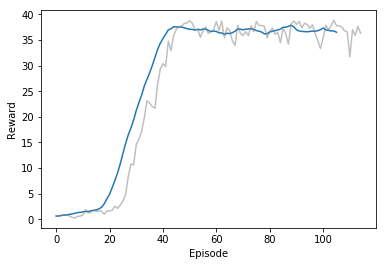

Elapsed time 0:57:30.579498


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from collections import deque
from datetime import datetime

from ddpg import DDPG

NUM_EPISODES = 300
SOLVED_IN= 30

start= datetime.now()

states, num_agents= env_reset(env, True)

# Hyperparameters
config= {
    "label": "Noisy layerNorm copy",
    "state_size": states.shape[1],
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "actor_nodes": [32, 32],
    "critic_nodes": [128, 128],
    "batch_size": 256,
    "memory_size": 100000,
    "discount": 0.9,
    "tau": 0.001,
    "action_noise": "No",    # Options: No, Normal, OU, 
    "sigma": 0.1,            # OUNoise, Normal
    "critic_l2_reg": 0.0,  # 1e-2
}


scores_window = deque(maxlen=100)
                     
agents= Agents(num_agents, config= config)

for episode in range(NUM_EPISODES):
    states, _= env_reset(env, True)
    agents.reset()
    score = np.zeros(num_agents)
    
    while True:
        actions= agents.act(states, False)    # Agent action. Include noise
        next_states, rewards, dones= env_step(env, actions)   # Environmet step
        # Agent step. Includes learnig from memory
        agents.step(states, actions, rewards, next_states, dones)
        
        score+= rewards        # update the score
        states= next_states     # roll over the state to next time step
        if np.any(dones):              # exit loop if episode finished
            break
    
    
    mean= np.mean(score)
    agents.update(mean)          # Add score to agents and update param noise
    scores_window.append(mean)       
    mean_w_scores= np.mean(scores_window)
    print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores), end="")
    if (episode+ 1) % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores))
    if mean_w_scores >= SOLVED_IN:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format((episode+ 1)-100, mean_w_scores))
        break
    
        
agents.save()


        
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_scores= running_mean(agents.scores, 10)
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores)
plt.plot(np.arange(len(agents.scores)), agents.scores, color='grey', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.show()
print('Elapsed time', datetime.now()- start)

### 4.- How the agents behave

In [10]:
states, num_agents= env_reset(env, False)

config= {
    "label": "Noisy layerNorm copy",
    "state_size": states.shape[1],
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "actor_nodes": [32, 32],
    "critic_nodes": [128, 128],
    "batch_size": 256,
    "memory_size": 100000,
    "discount": 0.9,
    "tau": 0.001,
    "action_noise": "No",    # Options: No, Normal, OU, 
    "sigma": 0.1,            # OUNoise, Normal
    "critic_l2_reg": 0.0,  # 1e-2
}

agents= Agents(num_agents, config= config)

agents.load()
agents.eval()

score = np.zeros(num_agents)                       # initialize the score
while True:
    actions= agents.act(states, False)
    next_states, rewards, dones= env_step(env, actions)
    score += rewards                                # update the score
    states= next_states   
    if np.any(dones):                                       # exit loop if episode finished
        break
    
print("\rFinal score: {:.1f}".format(np.max(score)))


Final score: 39.6
